In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
import tensorflow as tf
from keras.applications import inception_v3
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
sess = tf.compat.v1.Session(config=config)

from keras.applications import xception
from keras import backend as k

k.set_learning_phase(0)

model = xception.Xception(include_top=False, weights='imagenet') #imagenet 으로 학습된 모델 불러옴

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [89]:
model.summary() #모든 층의 이름확인

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_5[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

In [90]:
#층의 이름과 계수를 매핑한 딕셔너리 최대화 하려는 손실에 층의 활성화가 기여할 양을 정함 층이름은 xception에 하드코딩된 내용
layer_contributions = {
    #'block1_conv1_act':1., 
    'block2_pool':1.5,
    'block3_pool':2.5,
    'block4_pool':2.,
    #'block14_sepconv2_bn':2.,
    #'block11_sepconv1_act':0.2,
    'block14_sepconv2_act':0.2,
}


In [91]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])# 층 이름과 층 객체를 매핑한 딕셔너리를 만듬

loss = k.variable(0.) # 손실 정의 각 층의 기여 분을 스칼라 변수에 추가 기여 분은 아까 설정한 기여할 양 
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output #층의 출력을 얻음 (학습하고(한) 있는 내용)
    # 스케일링 및 이부분은 나도 찾아 봤는데 층 특성에 l2 노름 제곱을 손실에 추가 하는 것 + 이미지 테두리는 제외 넘파이 슬라이싱 이용
    scaling = k.prod(k.cast(k.shape(activation), 'float32')) 
    loss = loss + coeff * k.sum(k.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [92]:
dream = model.input # 딥드림 이미지 저장 output 의 결과물이 이미지임

grads = k.gradients(loss, dream)[0] #손실에 대한 딥드림 이미지의 그래디언트 계산(손실 최소화(x)최대화(0))
grads /= k.maximum(k.mean(k.abs(grads)), 1e-7) #그래디언트를 정규화해서 일정 범위안으로 값이 나오게 만드는거 

outputs = [loss, grads]
fetch_loss_and_grads = k.function([dream], outputs) # 주어진 입력 이미지에서 손실과 그래디언트 값을 계산할 케라스 함수 객체임

def eval_loss_and_grads(x): # 요기서 써먹음 저 사용자 함수를 쓰면 이미지 손실 값, 그래디언트 값 나옴 맞을꺼야 아무도 설명안해줘서 삽질함
    #아니면 정정 부탁
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 우리가 설정한 내용을 반복하여 수행함 최소의 손실구하듯이 우리는 최대를 구하기 위해서 최대를 구하는 이유는 딥러닝이 과잉해석하게 하기위함
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

In [93]:
import scipy
from tensorflow.keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = xception.preprocess_input(img)
    return img


def deprocess_image(x):
    if k.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [100]:
import numpy as np
from tqdm import tqdm

step = 0.01 # 경사상승법 단계 크기 얼만큼씩 오를지
num_octave = 3 # 경사 상승법을 실행할 특징 부분의 단계와 횟수  몇번째에 얼만큼? 인것 같아요
octave_scale = 1.4 # 특징강의 크기 비율 
iterations = 20 # 특징 단계마다 수행할 경사 상승법 정리하면 과잉해석 얼마나 이르킬꺼야? 정도

max_loss = 40. #손실이 40보다 커지면 그림이 이상해짐 이것을 피하기 위해 경사 상승법 중단

base_image_path = '/content/drive/MyDrive/AI/세특 프로젝트 모음집/image/horse.jpg'

img = preprocess_image(base_image_path) # 이미지를 넘파이 배열로 로드

#경사 상승법을 실행할 특징의 크기를 정의한 튜플 리스트 그냥 리스트임
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in tqdm(range(1, num_octave)):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1] # 넘파이 문법 리스트를 크기 순으로 뒤집음 작은것부터 딥드림 돌리고 특징추가 원본이미지 주입을 위함

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0]) #원본을 가장 작게 만듬

for shape in tqdm(successive_shapes):
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape) # 딥드림 이미지의 특징을 키움 (넘어갈때마다 1.4배씩 커짐)
    img = gradient_ascent(img,
                          iterations=iterations, #경사 상승법 실행 이미지 변경(상승하면 손실도가 달라지겠지? 그걸 적용하는 것 같음)
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape) # 작게 줄인 원본 이미지의 특징을 키움 픽셀 경계가 보일때까지
    same_size_original = resize_img(original_img, shape) # 이 크기에 해당하는 원본 이미지의 고해상도 버전을 찾음 (계산함)
    lost_detail = same_size_original - upscaled_shrunk_original_img # 이 두 키운 원본과 같은 크기의 특징 의 차이가 특징을 높였을때 손실된 이미지(원본)

    img += lost_detail # 없어진 디테일을 찾음 그림으로 치면 가장자리 뚤린거 찾아서 붙여준거임
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='/content/drive/MyDrive/AI/세특 프로젝트 모음집/save_image/final_horse.jpg')

  0%|          | 0/3 [00:00<?, ?it/s]

처리할 이미지 크기 (1137, 723)
... 0 번째 손실 : 13.048819
... 1 번째 손실 : 14.630077
... 2 번째 손실 : 16.920631
... 3 번째 손실 : 19.427362
... 4 번째 손실 : 22.012417
... 5 번째 손실 : 24.637844
... 6 번째 손실 : 27.251928
... 7 번째 손실 : 29.85577
... 8 번째 손실 : 32.418243
... 9 번째 손실 : 34.959274
... 10 번째 손실 : 37.44859
... 11 번째 손실 : 39.907333


 33%|███▎      | 1/3 [01:44<03:28, 104.44s/it]

처리할 이미지 크기 (1592, 1013)
... 0 번째 손실 : 18.808064
... 1 번째 손실 : 22.12094
... 2 번째 손실 : 25.144522
... 3 번째 손실 : 27.97728
... 4 번째 손실 : 30.712906
... 5 번째 손실 : 33.339626
... 6 번째 손실 : 35.899075
... 7 번째 손실 : 38.371834


 67%|██████▋   | 2/3 [04:06<02:06, 126.65s/it]

처리할 이미지 크기 (2229, 1419)
... 0 번째 손실 : 19.796017
... 1 번째 손실 : 23.019775
... 2 번째 손실 : 26.017511
... 3 번째 손실 : 28.847948
... 4 번째 손실 : 31.595423
... 5 번째 손실 : 34.240906
... 6 번째 손실 : 36.812023
... 7 번째 손실 : 39.306168


100%|██████████| 3/3 [08:41<00:00, 173.92s/it]


In [101]:
from matplotlib import pyplot as plt

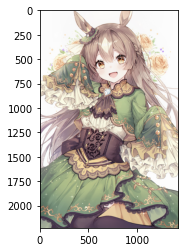

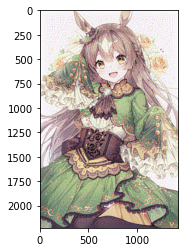

In [102]:
plt.imshow(plt.imread(base_image_path))
plt.figure()

plt.imshow(deprocess_image(np.copy(img)))
plt.show()